# Remarks #

* It is preferable to download this Jupyter Notebook and upload it on google drive then running it.
* A large dataset will be downloaded for this project. Among the data, you may choose the number of samplngs that you may use when running the notebook.

# Objective #


1.   First, we will collect various samples of the COCO dataset and filter out the nouns for each sample.
  * We used a relatively small sample compared to the actual data amount due to hardware limitations.
2.   Then, we will filter out the nouns and compare it with each other, and measure the cosine similarity.
3. We will then show a graphical representation of how similar the items are.

![alt text](https://miro.medium.com/max/442/1*UODvtQMybHE8c0eL3K5z5A.png)


   4.  We will use gensim topic modelling to train our data to see if the model can predict scenes that are similar. 
       * We discarded all the parts of the caption data, with the exception of nouns.
       * By treating the bag of captions as a document and each caption list as a bag of words, we trained our data and tested it to see if genism successfully was able to predict similar scenes.
   5. We will also show a graphical representation of such, to emphasise our observations and to draw conclusions.


![alt text](https://miro.medium.com/max/886/1*yiH5sZI-IBxDSQMKhvbcHw.png)

# Import Statements #

We will first import the appropriate modules which we will be using right now.

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle
print("Imported")

Imported


# Import Dataset #

We will download the COCO dataset.

> Indented block



In [0]:
annotation_folder = '/annotations/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
  annotation_zip = tf.keras.utils.get_file('captions.zip',
                                          cache_subdir=os.path.abspath('.'),
                                          origin = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                          extract = True)
  annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
  os.remove(annotation_zip)
image_folder = '/train2014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin = 'http://images.cocodataset.org/zips/train2014.zip',
                                      extract = True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else:
  PATH = os.path.abspath('.') + image_folder

We will restrict the training size by setting up a certain limit. This case, we are using 10000 samples.

In [0]:
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

all_captions = []
all_img_name_vector = []

for annot in annotations['annotations']:
    caption = '<start> ' + annot['caption'] + ' <end>'
    image_id = annot['image_id']
    full_coco_image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (image_id)

    all_img_name_vector.append(full_coco_image_path)
    all_captions.append(caption)

train_captions, img_name_vector = shuffle(all_captions,
                                          all_img_name_vector,
                                          random_state=1)
num_examples = 13000
train_captions = train_captions[:num_examples]
img_name_vector = img_name_vector[:num_examples]

In [0]:
len(train_captions)

13000

# Extracting the Nouns from the Restricted Dataset

Now that we have limited the datatset for training, we will construct an algorithm so that we are able to filter out the nouns.

We wil use NLTK library, to filter out the nouns.

Incase your NLTK packages are not downloaded, this jupyter notebook will allow you to download the 'punkt' package and the 'averaged_perceptron_tagger' package. 



In [0]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

def filter_nouns(data):
    i = 0
    nouns = None
    noun_list = []
    while i < len(data):
        lines = ''.join(data[i])
        # function to test if something is a noun
        is_noun = lambda pos: pos[:2] == 'NN'
        # do the nlp stuff
        tokenized = nltk.word_tokenize(lines)
        nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)] 
        noun_list = [*noun_list, nouns]
        i += 1     
    return noun_list

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [0]:
def filter(document):
    i = 0
    df = None
    noun_list = []
    while i < len(document):
        
        # Filter out components that are not needed 
        # Convert list of strings to natural language
        while 'A' in document[i]: document[i].remove('A')
        while 'start' in document[i]: document[i].remove('start')
        while 'end' in document[i]: document[i].remove('end')
        while '>' in document[i]: document[i].remove('>')
        while '<' in document[i]: document[i].remove('<')
        noun_str = ' '.join(document[i])
        noun_list = [*noun_list, noun_str]
        
        i += 1
    return noun_list
filter(filter_nouns(train_captions))

ERROR! Session/line number was not unique in database. History logging moved to new session 62


['skateboarder trick skateboard ramp',
 'person air skis',
 'wood door boards',
 'Do Enter sign road stadium',
 'Small child chair plate',
 'groups people toilet area',
 'hand cellphone',
 'People computers student room',
 'birds field',
 'man cell phone park',
 'group men table microphones speech',
 'bathroom toilet sprayer wall',
 'woman bench phone',
 'woman clock purse market',
 'surfer hand signal',
 'cat asphalt',
 'carrots cut squash carrots',
 'Traffic lights intersection world',
 'man goatee backseat vehicle luggage',
 'street sign intersection Beacon Ave Stevens St.',
 'kid skateboard kid',
 'apple clock display',
 'bunch color watches table',
 'man suit standing front stove',
 'Pizzas sauce cheese table',
 'variety vegetables sticks tray control',
 'bus road driver',
 'pizza cut pieces top counter',
 'plate breakfast food eggs toast hash browns',
 'transit bus lot',
 'man air skateboard',
 'ground plane',
 'person bananas back',
 'Three zebras field grass',
 'couple pieces t

# Cosine similarity # 

## Cosine Similarity Analysis ##

To understand how related these image captions are, we attempted to yield a generalised idea by finding its cosine similarity of nouns in each scene. 

With the obtained list of lists which contains the nouns for each training set, we will now calculate the cosine similarity and plot a visual representation of how similar each captions are.

We will first construct a document-term matrix. 


In [0]:
# Define the bag of captions 
import numpy as np
captions = filter(filter_nouns(train_captions))

In [0]:
# import appropriate models
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

def construct_matrix(document):   
    # Create the Document Term Matrix
    count_vectorizer = TfidfVectorizer(stop_words='english')
    count_vectorizer = TfidfVectorizer()
    
    # Define the matrix
    sparse_matrix = count_vectorizer.fit_transform(document)

    #  Convert Sparse Matrix to Pandas Dataframe to see the word frequencies.
    doc_term_matrix = sparse_matrix.todense()
    
    #  Label each row with the appropriate caption
    count = 0
    numbers = []
    while count < len(document):
        count += 1
        numbers = [*numbers, "Caption {}".format(len(numbers) + 1)]
    
    df = pd.DataFrame(doc_term_matrix, 
                  columns=count_vectorizer.get_feature_names(), 
                  index=[x for x in numbers]) 
    return df

matrix = construct_matrix(captions)
observations = np.shape(matrix)[0]
features = np.shape(matrix)[1]

print("The data has {} observations and {} features.".format(observations, \
                                                             features))
print(matrix)

The data has 13000 observations and 3900 features.
                51  aarons  abandon  accent  ...  zipper  zone  zoo  zucchini
Caption 1      0.0     0.0      0.0     0.0  ...     0.0   0.0  0.0       0.0
Caption 2      0.0     0.0      0.0     0.0  ...     0.0   0.0  0.0       0.0
Caption 3      0.0     0.0      0.0     0.0  ...     0.0   0.0  0.0       0.0
Caption 4      0.0     0.0      0.0     0.0  ...     0.0   0.0  0.0       0.0
Caption 5      0.0     0.0      0.0     0.0  ...     0.0   0.0  0.0       0.0
...            ...     ...      ...     ...  ...     ...   ...  ...       ...
Caption 12996  0.0     0.0      0.0     0.0  ...     0.0   0.0  0.0       0.0
Caption 12997  0.0     0.0      0.0     0.0  ...     0.0   0.0  0.0       0.0
Caption 12998  0.0     0.0      0.0     0.0  ...     0.0   0.0  0.0       0.0
Caption 12999  0.0     0.0      0.0     0.0  ...     0.0   0.0  0.0       0.0
Caption 13000  0.0     0.0      0.0     0.0  ...     0.0   0.0  0.0       0.0

[13000 rows 

Now that we have successfully generated a document term matrix, we will compute the cosine similarity and display the output, using sklearn.metrics.

In [0]:
# Compute Cosine Similarity
from sklearn.metrics.pairwise import cosine_similarity

cos_sim = cosine_similarity(matrix, matrix)
# print(np.shape(cos_sim))
print(cos_sim)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


We will visualise this computed cosine similarity matrix by clustering in terms of k-means.

Before that, we will do a principle component analysis to reduce the dimensions of the data, and find the optimal clusters.

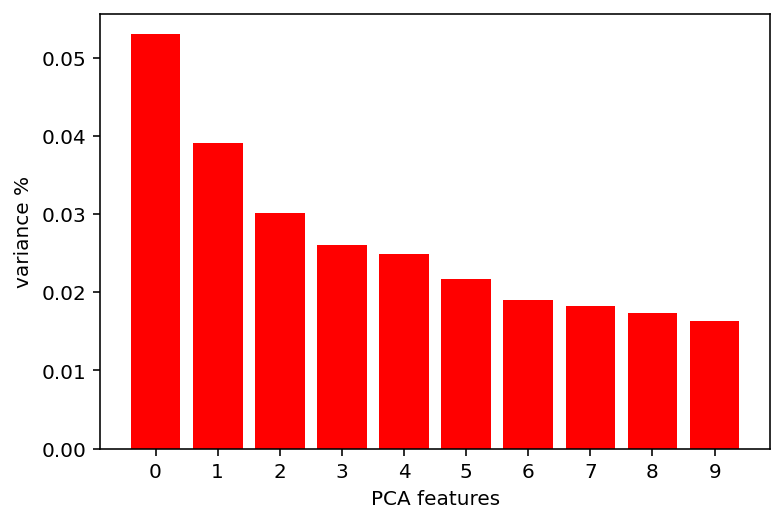

In [0]:
# Imports
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
%config InlineBackend.figure_format='retina'

# Load in the data
df = cosine_similarity(matrix, matrix)
# Standardize the data to have a mean of ~0 and a variance of 1
X_std = StandardScaler().fit_transform(df)
# Create a PCA instance: pca
pca = PCA(n_components=10)
principalComponents = pca.fit_transform(X_std)
# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='red')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
# Save components to a DataFrame
PCA_components = pd.DataFrame(principalComponents)

Here we see a variance drop after the first component.

Text(0, 0.5, 'PCA 2')

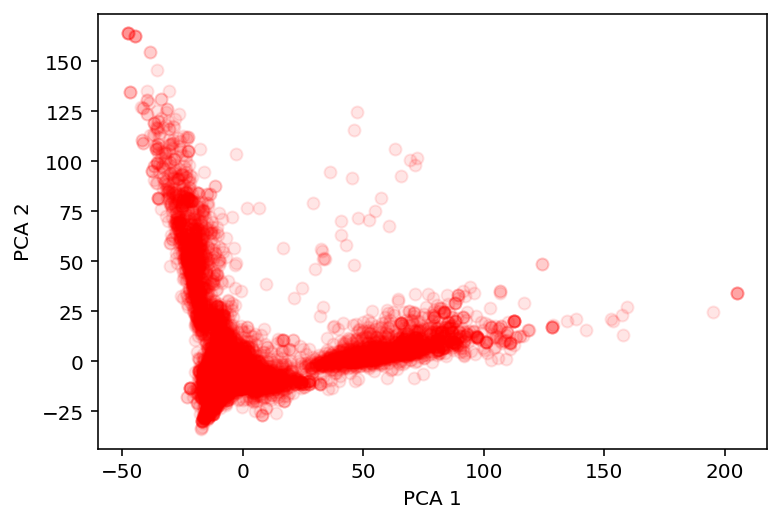

In [0]:
plt.scatter(PCA_components[0], PCA_components[1], alpha=.1, color='red')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

We must find the sum of squared distances of samples to their closest cluster center to determine the optimal clustering.

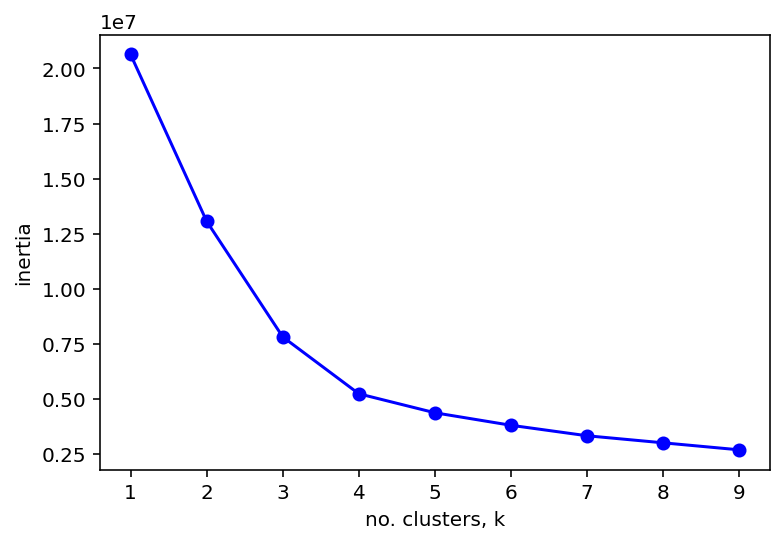

In [0]:
ks = range(1, 10)
inertias = []
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(PCA_components.iloc[:,:3])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='blue')
plt.xlabel('no. clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

We see an elbow point at around 2~3 clusters. We will use 2 clusters as our optimal number of clusters.

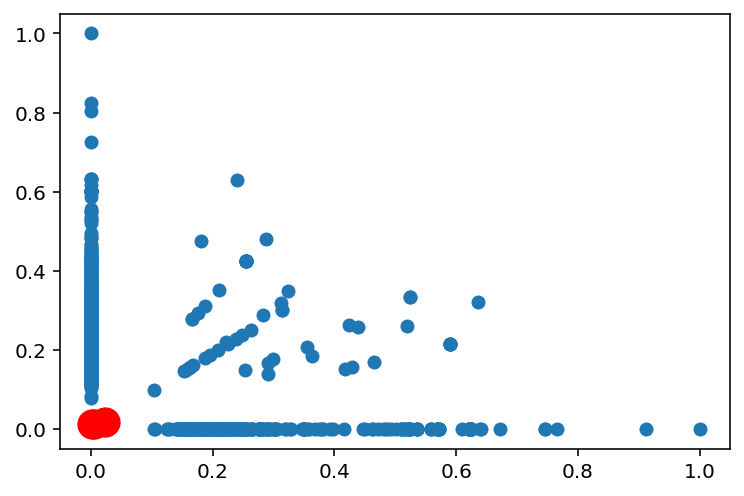

In [0]:
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(df)
plt.scatter(df[:,0], df[:,1])
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=200, c='red')
plt.show()

## Matthew edit this box and please expand on the analysis. ##

From the plots, most of the data are heavily centered away, so the scenes are not as similar. 


## Predicting Nouns with similarity##

Now, we will use a Topic Modelling Gensim Library to train, and and map out the similar nouns, despite the dissimilarity. We will compare this with cosine similarity and map out a visual representation.

We will treat each caption as the documents, and then the nouns within those captions as a bag of words. Using this we will construct a function to add tags to the document, and train it. 


In [0]:
import gensim

In [0]:
def read_corpus(f, tokens_only=False):
    for i, line in enumerate(f):
        tokens = gensim.utils.simple_preprocess(line)
        if tokens_only:
            yield tokens
        else:
            # For training data, add tags
            yield gensim.models.doc2vec.TaggedDocument(tokens, [i])

We will limit the data and use 1000, as larger data with high varying degrees of similarity may cause a very long runtime.

In [187]:
R = list(read_corpus(captions))
r = R[:1000]

print(r)

[TaggedDocument(words=['skateboarder', 'trick', 'skateboard', 'ramp'], tags=[0]), TaggedDocument(words=['person', 'air', 'skis'], tags=[1]), TaggedDocument(words=['wood', 'door', 'boards'], tags=[2]), TaggedDocument(words=['do', 'enter', 'sign', 'road', 'stadium'], tags=[3]), TaggedDocument(words=['small', 'child', 'chair', 'plate'], tags=[4]), TaggedDocument(words=['groups', 'people', 'toilet', 'area'], tags=[5]), TaggedDocument(words=['hand', 'cellphone'], tags=[6]), TaggedDocument(words=['people', 'computers', 'student', 'room'], tags=[7]), TaggedDocument(words=['birds', 'field'], tags=[8]), TaggedDocument(words=['man', 'cell', 'phone', 'park'], tags=[9]), TaggedDocument(words=['group', 'men', 'table', 'microphones', 'speech'], tags=[10]), TaggedDocument(words=['bathroom', 'toilet', 'sprayer', 'wall'], tags=[11]), TaggedDocument(words=['woman', 'bench', 'phone'], tags=[12]), TaggedDocument(words=['woman', 'clock', 'purse', 'market'], tags=[13]), TaggedDocument(words=['surfer', 'hand

Now we will train it.

In [0]:
import multiprocessing 

cores = multiprocessing.cpu_count() # Count the number of cores in a computer

model = gensim.models.doc2vec.Doc2Vec(vector_size=40, min_count=2, epochs=30, 
                                      workers=cores-1)

In [189]:
t = time.time()

model.build_vocab(r, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time.time() - t) / 60, 2)))

Time to build vocab: 0.01 mins


In [190]:

model.train(r, total_examples=model.corpus_count, epochs=model.epochs)

print('Time to train the model: {} mins'.format(round((time.time() - t) / 60, 2)))

Time to train the model: 0.05 mins


In [278]:
print(r)

[['skateboarder', 'trick', 'skateboard', 'ramp'], ['person', 'air', 'skis'], ['wood', 'door', 'boards'], ['do', 'enter', 'sign', 'road', 'stadium'], ['small', 'child', 'chair', 'plate'], ['groups', 'people', 'toilet', 'area'], ['hand', 'cellphone'], ['people', 'computers', 'student', 'room'], ['birds', 'field'], ['man', 'cell', 'phone', 'park'], ['group', 'men', 'table', 'microphones', 'speech'], ['bathroom', 'toilet', 'sprayer', 'wall'], ['woman', 'bench', 'phone'], ['woman', 'clock', 'purse', 'market'], ['surfer', 'hand', 'signal'], ['cat', 'asphalt'], ['carrots', 'cut', 'squash', 'carrots'], ['traffic', 'lights', 'intersection', 'world'], ['man', 'goatee', 'backseat', 'vehicle', 'luggage'], ['street', 'sign', 'intersection', 'beacon', 'ave', 'stevens', 'st'], ['kid', 'skateboard', 'kid'], ['apple', 'clock', 'display'], ['bunch', 'color', 'watches', 'table'], ['man', 'suit', 'standing', 'front', 'stove'], ['pizzas', 'sauce', 'cheese', 'table'], ['variety', 'vegetables', 'sticks', 'tr

## Assessing the Model ##

To assess our model, first, we’ll first infer new vectors for each document of the training corpus.

We will then compare it with the original caption and return the ranks based on how similar they are..


Due to our data being very different, despite the ideal situation where overfittig the model is desirable, we expect that it will yield a close result.


We will print out the documents and scenes.

In [191]:
ranks = []
second_ranks = []
for doc_id in range(len(r)):
    inferred_vector = model.infer_vector(r[doc_id].words)
    sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))
    rank = [docid for docid, sim in sims].index(doc_id)
    ranks.append(rank)

    second_ranks.append(sims[1])

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [192]:
import collections

counter = collections.Counter(ranks)
print(counter)

Counter({602: 6, 795: 5, 944: 5, 722: 5, 245: 5, 136: 4, 423: 4, 408: 4, 426: 4, 615: 4, 35: 4, 501: 4, 384: 4, 346: 4, 476: 4, 820: 4, 89: 4, 468: 4, 824: 4, 40: 4, 556: 3, 873: 3, 219: 3, 455: 3, 450: 3, 153: 3, 677: 3, 965: 3, 91: 3, 41: 3, 794: 3, 439: 3, 318: 3, 747: 3, 127: 3, 605: 3, 474: 3, 431: 3, 295: 3, 983: 3, 844: 3, 838: 3, 776: 3, 688: 3, 629: 3, 633: 3, 15: 3, 924: 3, 205: 3, 20: 3, 891: 3, 5: 3, 523: 3, 945: 3, 313: 3, 305: 3, 118: 3, 818: 3, 114: 3, 246: 3, 93: 3, 115: 3, 826: 3, 673: 3, 529: 3, 973: 3, 551: 3, 596: 3, 337: 3, 204: 3, 358: 3, 415: 3, 437: 3, 416: 3, 696: 3, 607: 3, 661: 3, 405: 3, 435: 3, 715: 3, 349: 3, 230: 3, 353: 3, 83: 3, 3: 3, 761: 3, 265: 3, 133: 3, 101: 2, 105: 2, 784: 2, 662: 2, 726: 2, 952: 2, 707: 2, 788: 2, 610: 2, 954: 2, 535: 2, 269: 2, 409: 2, 905: 2, 71: 2, 646: 2, 543: 2, 527: 2, 67: 2, 580: 2, 899: 2, 303: 2, 181: 2, 811: 2, 733: 2, 212: 2, 760: 2, 169: 2, 291: 2, 456: 2, 263: 2, 17: 2, 837: 2, 681: 2, 361: 2, 850: 2, 911: 2, 771: 2,

We see that there are five ranks of variation of how similar each caption's noun list is.

Below is a test on the dataset itself. We will see if this model detects reasonably a similar scene, from similar to dissimilar.

Note that the result may vary, due to randomised indicies. 

In [193]:
print('Document ({}): «{}»\n'.format(doc_id, ' '.join(r[doc_id].words)))
print(u'SIMILAR/DISSIMILAR DOCS PER MODEL %s:\n' % model)
for label, index in [('MOST', 0), ('SECOND-MOST', 1), ('MEDIAN', len(sims)//2), ('LEAST', len(sims) - 1)]:
    print(u'%s %s: «%s»\n' % (label, sims[index], ' '.join(r[sims[index][0]].words)))

Document (999): «well businessman parking lot»

SIMILAR/DISSIMILAR DOCS PER MODEL Doc2Vec(dm/m,d40,n5,w5,mc2,s0.001):

MOST (794, 0.9920157194137573): «couple of giraffes in the wild walking in the sand»

SECOND-MOST (783, 0.9911683797836304): «living room area table chairs bar stools counter top television»

MEDIAN (396, 0.9554594159126282): «lion chair table»

LEAST (404, -0.2596120834350586): «frolicking shrubbery»



In [194]:
# Pick a random document from the corpus and infer a vector from the model
import random
doc_id = random.randint(0, len(r) - 1)

# Compare and print the second-most-similar document
print('Train Document ({}): «{}»\n'.format(doc_id, ' '.join(r[doc_id].words)))
sim_id = second_ranks[doc_id]
print('Similar Document {}: «{}»\n'.format(sim_id, ' '.join(r[sim_id[0]].words)))

Train Document (716): «wood dining room table chairs sits room leather chair»

Similar Document (733, 0.9962451457977295): «view street traffic buses cars motorcycle rider trees buildings»



### Model Test ###

Now we will input related strings into the predictor and produce two inferred vectors and compute its cosine similarity see how close the two vectors that this model has inferred in two different strings.

In [268]:
predictor1 = ['skateboard', 'park', 'ball']
vector1 = model.infer_vector(predictor1)
print(vector1)

[ 0.0560973   0.02087294  0.00180406  0.09710477  0.02333952  0.07255014
  0.06565705 -0.02230296 -0.07310336 -0.00193053  0.02880027  0.02730857
  0.08376947 -0.04046534  0.02650589  0.06919712 -0.03841364  0.08937874
  0.07742574  0.03510408 -0.12007035  0.03933863 -0.04093681 -0.06311447
 -0.14468518  0.04291464 -0.08864843 -0.09914405 -0.09048756 -0.11178316
 -0.13620527  0.04812532 -0.08467326 -0.10183536  0.04535187 -0.00438034
  0.07035069  0.03395114 -0.0795885   0.02704406]


In [269]:
predictor2 = ['skateboard', 'park', 'ball']
vector2 = model.infer_vector(predictor2)
print(vector2)

[ 0.0470546   0.0182476   0.00309396  0.08058     0.02001555  0.06013324
  0.0564094  -0.01808879 -0.06304573 -0.00117356  0.02491001  0.02284865
  0.07245806 -0.03306089  0.02349225  0.05919446 -0.03202067  0.07703348
  0.06495262  0.02741354 -0.10209163  0.03459143 -0.03395511 -0.05330769
 -0.12331484  0.03786299 -0.07471219 -0.08272516 -0.07858968 -0.09736083
 -0.11742573  0.04197249 -0.07234819 -0.08617231  0.03811171 -0.00478465
  0.0584606   0.02672559 -0.06730628  0.02235813]


In [270]:
from scipy import spatial

result = 1 - spatial.distance.cosine(vector1, vector2)
print(result)

0.9998189210891724


If we change the input string into something else, the cosine similarity varies. In this case, we have entered a completely unrelated predictor, which predicted a vector that is far from similar.

In [271]:
predictor2 = ['angry', 'bad', 'hello']
vector2 = model.infer_vector(predictor2)
print(vector2)

[-0.00753467  0.00846924 -0.00795946  0.00313274  0.00587448  0.00163562
  0.0108287  -0.00280833 -0.00856584  0.005291    0.00797991  0.00445892
  0.00711466  0.00342442  0.00371753  0.01115284  0.00361398 -0.00637501
 -0.00527698 -0.0046436  -0.0006466   0.01152344  0.0079599  -0.00840125
 -0.00846403 -0.00880434 -0.00732999 -0.00931043 -0.01054741  0.00065712
  0.00601443  0.00011732  0.00846152  0.00660248  0.00059417  0.00370222
 -0.01074943 -0.01123463  0.00943444  0.00393857]


In [272]:
result = 1 - spatial.distance.cosine(vector1, vector2)
print(result)

0.10725320875644684


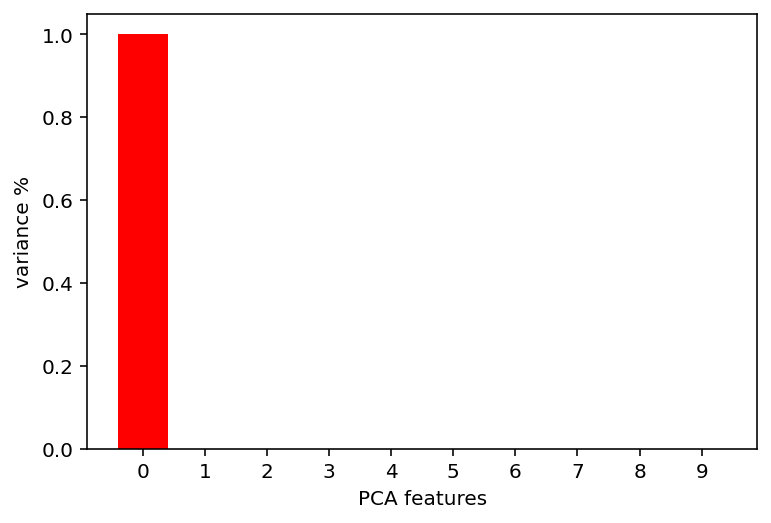

In [207]:
# Imports
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
%config InlineBackend.figure_format='retina'

# Load in the data
df = cos_sim_vec
# Standardize the data to have a mean of ~0 and a variance of 1
X_std = StandardScaler().fit_transform(df)
# Create a PCA instance: pca
pca = PCA(n_components=10)
principalComponents = pca.fit_transform(X_std)
# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='red')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
# Save components to a DataFrame
PCA_components = pd.DataFrame(principalComponents)

## Matthew edit this box and please write the analysis here. ##